In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

In [2]:
BASE_DIR = Path().resolve().parent
BASE_DIR

PosixPath('/home/sadegh/python_projects/teesside/nencki_institute')

In [3]:
CSV_DIR = BASE_DIR / "data/features_final"
CSV_DIR

PosixPath('/home/sadegh/python_projects/teesside/nencki_institute/data/features_final')

In [4]:
dfs = {}

for csv_file in CSV_DIR.glob('*.csv'):
    df_name = csv_file.stem
    dfs[df_name] = pd.read_csv(csv_file)

In [5]:
markers = {
    "CD68": "CD68: Mean",
    "TMEM119": "TMEM119: Mean",
    "CD45": "CD45: Mean",
    "GPNMB": "GPNMB: Mean"
}

exclude_ids = {"2506", "2503", "4152", "4155", "4156", "17827"}

results = []

for file_name, df in dfs.items():

    patient_id = file_name.split(".")[0]

    required_p1 = ["CD68", "TMEM119", "CD45"]

    if not all(markers[m] in df.columns for m in required_p1):
        print(f"Skipping {patient_id}: missing required markers for Problem 1")
        continue

    thresholds = {
        marker: df[markers[marker]].mean()
        for marker in required_p1
    }

    CD68_pos = df[markers["CD68"]] > thresholds["CD68"]
    TMEM119_pos = df[markers["TMEM119"]] > thresholds["TMEM119"]
    CD45_pos = df[markers["CD45"]] > thresholds["CD45"]

    triple_pos = CD68_pos & TMEM119_pos & CD45_pos
    tmem_neg = CD68_pos & (~TMEM119_pos) & CD45_pos

    total_cells = len(df)   # <-- total cells per biopsy

    row = {
        "Biopsy": patient_id,
        "Total_cells": total_cells,  # <-- ADDED
        "TMEM119pos_count": triple_pos.sum(),
        "TMEM119neg_count": tmem_neg.sum()
    }

    if (
        markers["GPNMB"] in df.columns
        and patient_id not in exclude_ids
        and CD45_pos.sum() > 0
    ):

        thresholds["GPNMB"] = df[markers["GPNMB"]].mean()
        GPNMB_pos = df[markers["GPNMB"]] > thresholds["GPNMB"]

        GPNMB_pos_MG = (GPNMB_pos & CD68_pos & TMEM119_pos & CD45_pos).sum()
        GPNMB_neg_MG = ((~GPNMB_pos) & CD68_pos & TMEM119_pos & CD45_pos).sum()
        GPNMB_pos_Mphi = (GPNMB_pos & CD68_pos & (~TMEM119_pos) & CD45_pos).sum()
        GPNMB_neg_Mphi = ((~GPNMB_pos) & CD68_pos & (~TMEM119_pos) & CD45_pos).sum()

        total_CD45 = CD45_pos.sum()

        row.update({
            "% GPNMB+ MG": 100 * GPNMB_pos_MG / total_CD45,
            "% GPNMB- MG": 100 * GPNMB_neg_MG / total_CD45,
            "% GPNMB+ MΦ": 100 * GPNMB_pos_Mphi / total_CD45,
            "% GPNMB- MΦ": 100 * GPNMB_neg_Mphi / total_CD45
        })

    results.append(row)

final_results = pd.DataFrame(results)
final_results

,Biopsy,Total_cells,TMEM119pos_count,TMEM119neg_count,% GPNMB+ MG,% GPNMB- MG,% GPNMB+ MΦ,% GPNMB- MΦ
0,biopsy_926_upper,237,25,29,15.238095,8.571429,22.857143,4.761905
1,biopsy_5113_bottom,14185,1967,1341,18.395744,21.853898,8.696542,18.743605
2,biopsy_3149_upper,12817,646,2619,5.664133,6.026059,21.588853,25.805284
3,biopsy_2087_upper,487,102,7,14.655172,29.310345,2.155172,0.862069
4,biopsy_5731_bottom,1544,313,105,5.323741,39.712230,10.791367,4.316547
5,biopsy_2503_upper,623,44,59,NaN,NaN,NaN,NaN
6,biopsy_4152_upper,722,83,43,NaN,NaN,NaN,NaN
7,biopsy_4891_upper,121,33,1,54.901961,9.803922,0.000000,1.960784
8,biopsy_4155_bottom,9385,649,610,NaN,NaN,NaN,NaN
9,biopsy_1686_bottom,1375,119,58,23.300971,15.210356,5.177994,13.592233


In [6]:
final_results["biopsy_number"] = (
    final_results["Biopsy"]
    .str.extract(r'biopsy_(\d+)_')
    .astype(str)
)

final_results["position"] = (
    final_results["Biopsy"]
    .str.extract(r'biopsy_\d+_(upper|bottom)')
)

final_results

,Biopsy,Total_cells,TMEM119pos_count,TMEM119neg_count,% GPNMB+ MG,% GPNMB- MG,% GPNMB+ MΦ,% GPNMB- MΦ,biopsy_number,position
0,biopsy_926_upper,237,25,29,15.238095,8.571429,22.857143,4.761905,926,upper
1,biopsy_5113_bottom,14185,1967,1341,18.395744,21.853898,8.696542,18.743605,5113,bottom
2,biopsy_3149_upper,12817,646,2619,5.664133,6.026059,21.588853,25.805284,3149,upper
3,biopsy_2087_upper,487,102,7,14.655172,29.310345,2.155172,0.862069,2087,upper
4,biopsy_5731_bottom,1544,313,105,5.323741,39.712230,10.791367,4.316547,5731,bottom
5,biopsy_2503_upper,623,44,59,NaN,NaN,NaN,NaN,2503,upper
6,biopsy_4152_upper,722,83,43,NaN,NaN,NaN,NaN,4152,upper
7,biopsy_4891_upper,121,33,1,54.901961,9.803922,0.000000,1.960784,4891,upper
8,biopsy_4155_bottom,9385,649,610,NaN,NaN,NaN,NaN,4155,bottom
9,biopsy_1686_bottom,1375,119,58,23.300971,15.210356,5.177994,13.592233,1686,bottom


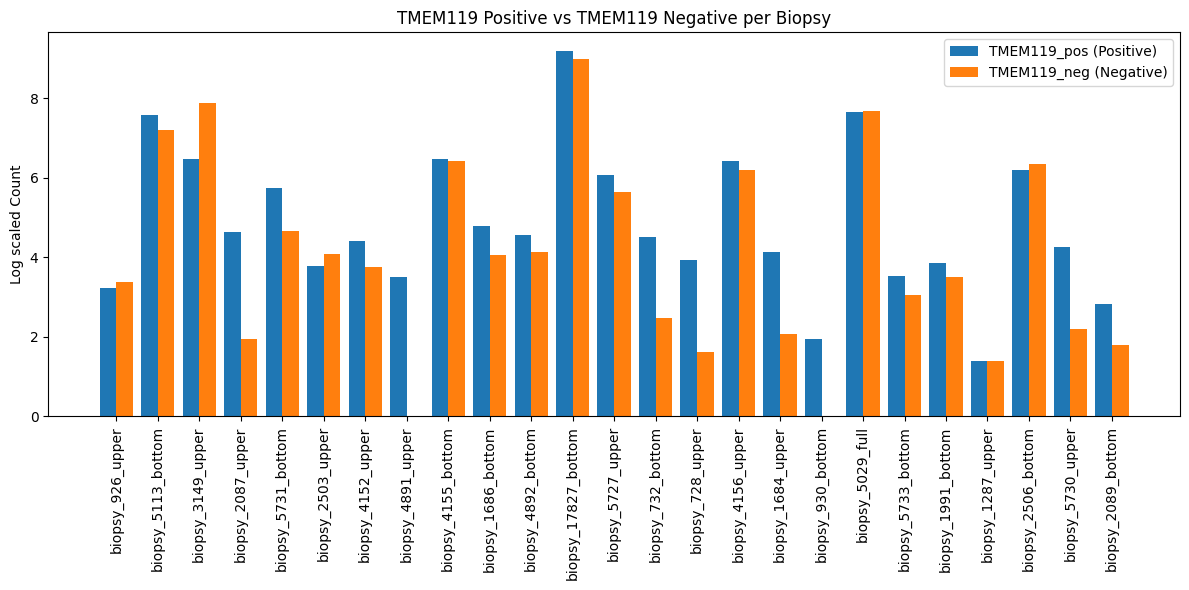

In [7]:
x = np.arange(len(final_results))
width = 0.4

plt.figure(figsize=(12,6))

plt.bar(x - width/2, np.log(final_results["TMEM119pos_count"]), width, label="TMEM119_pos (Positive)")
plt.bar(x + width/2, np.log(final_results["TMEM119neg_count"]), width, label="TMEM119_neg (Negative)")

plt.xticks(x, final_results["Biopsy"], rotation=90)
plt.ylabel("Log scaled Count")
plt.title("TMEM119 Positive vs TMEM119 Negative per Biopsy")
plt.legend()

plt.tight_layout()
plt.show()


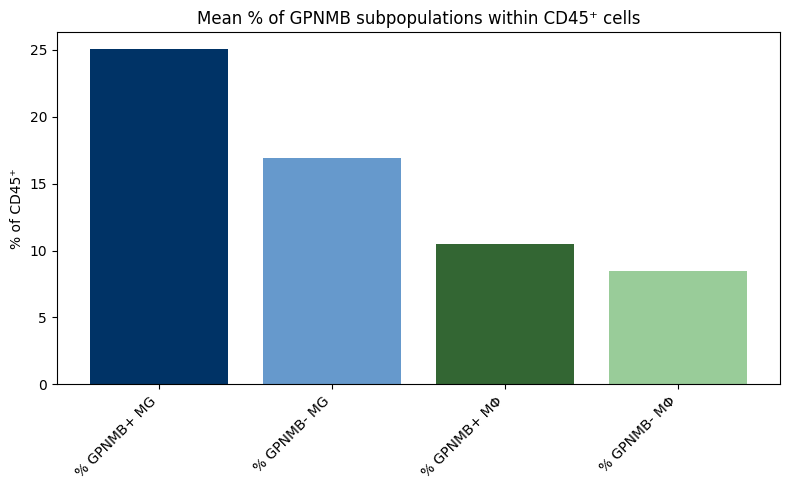

In [8]:
cols = ["% GPNMB+ MG", "% GPNMB- MG", "% GPNMB+ MΦ", "% GPNMB- MΦ"]

means = final_results[cols].mean()

colors = ['#003366', '#6699cc', '#336633', '#99cc99']

plt.figure(figsize=(8,5))
bars = plt.bar(means.index, means.values, color=colors)

plt.ylabel("% of CD45⁺")
plt.xticks(rotation=45, ha='right')
plt.title("Mean % of GPNMB subpopulations within CD45⁺ cells")
plt.tight_layout()

plt.show()

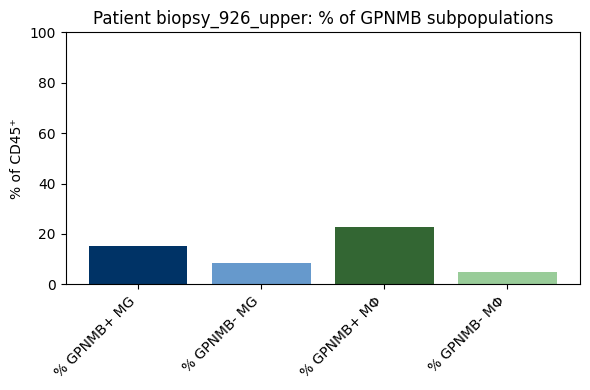

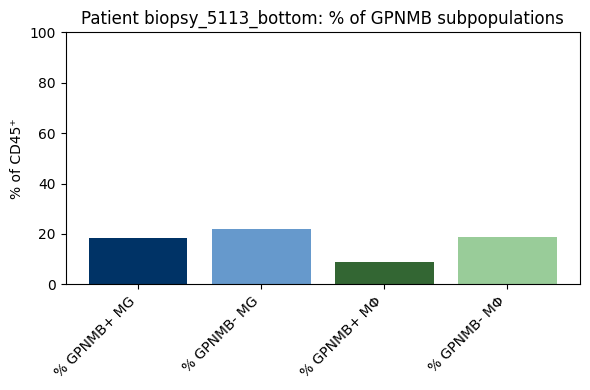

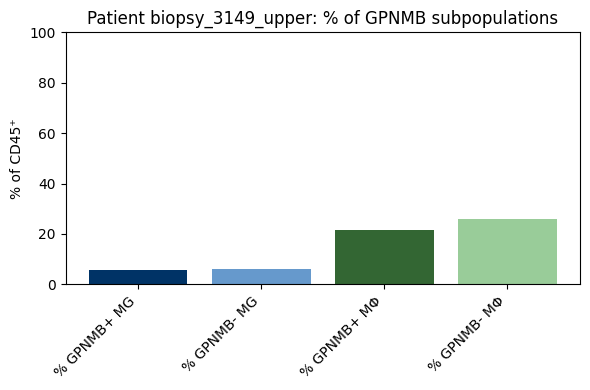

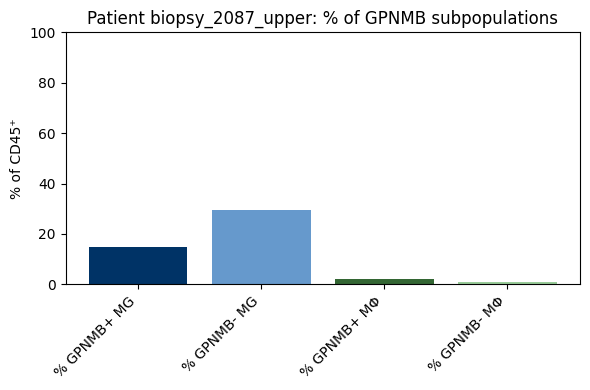

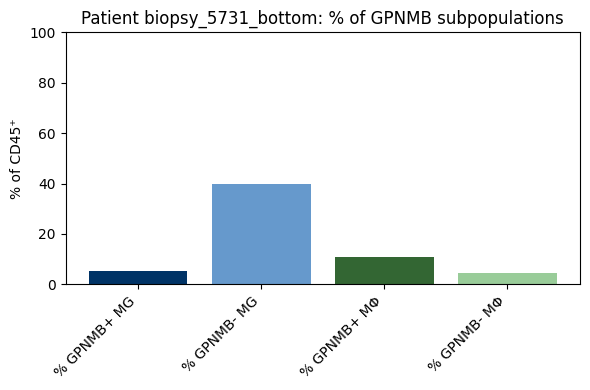

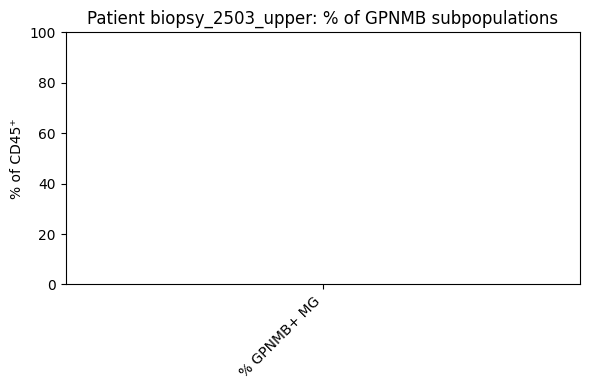

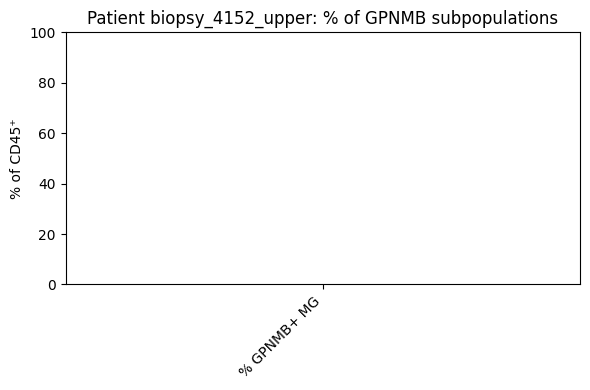

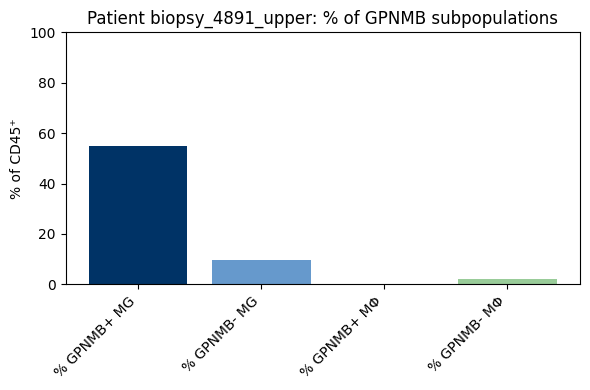

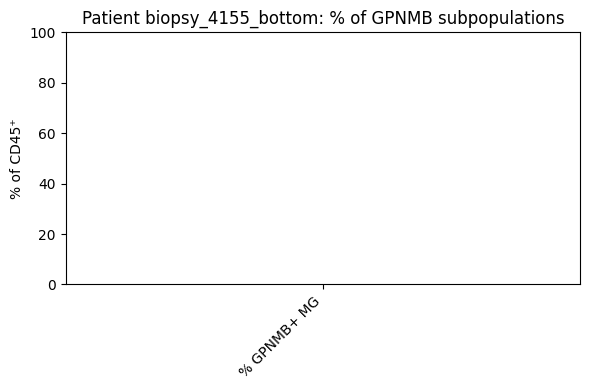

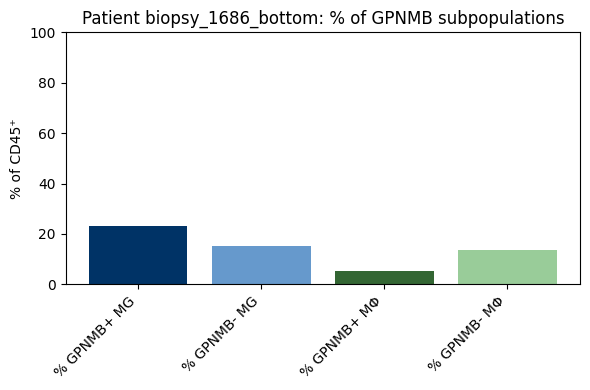

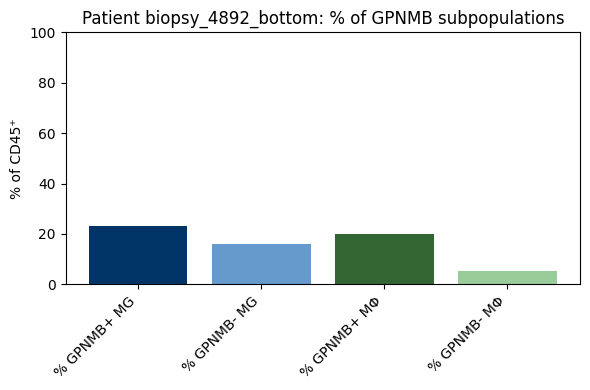

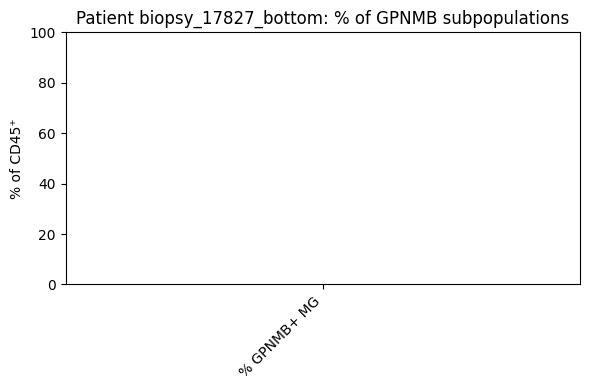

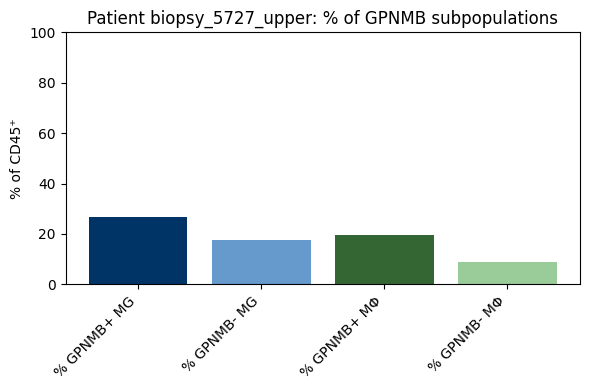

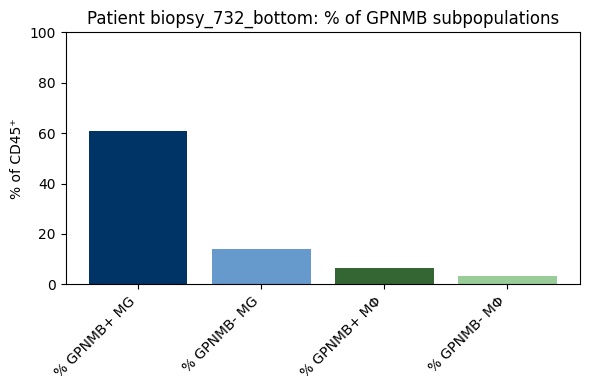

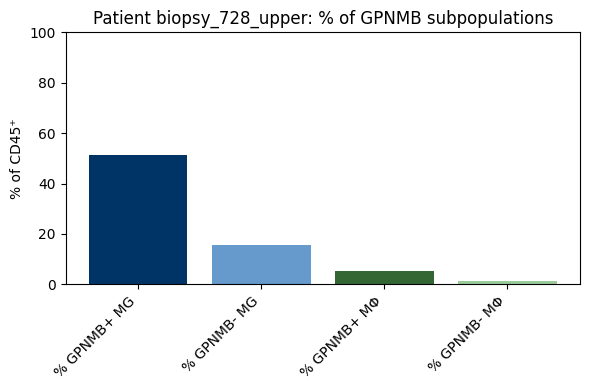

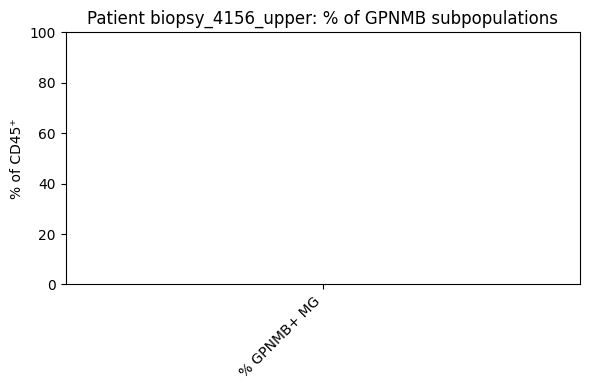

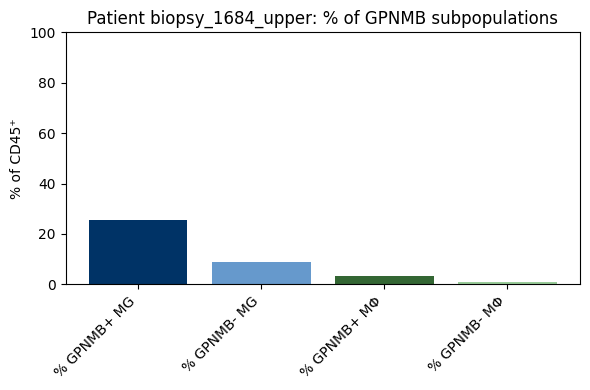

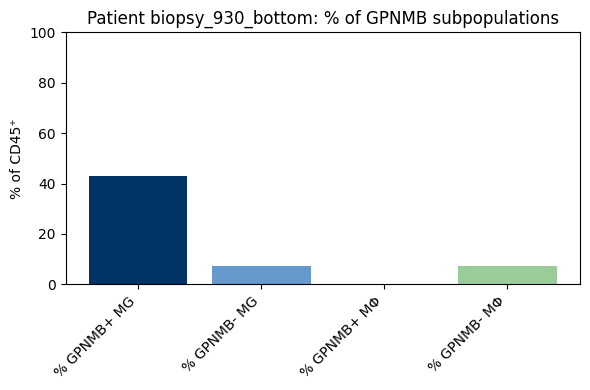

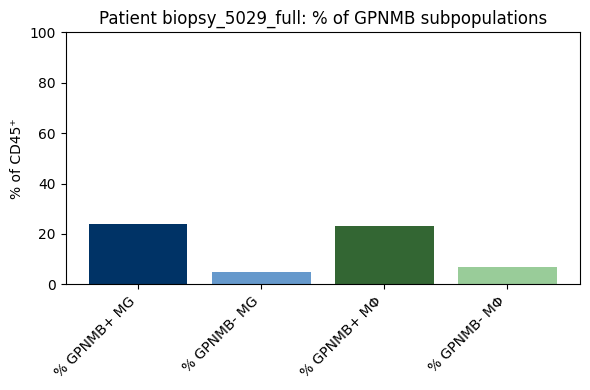

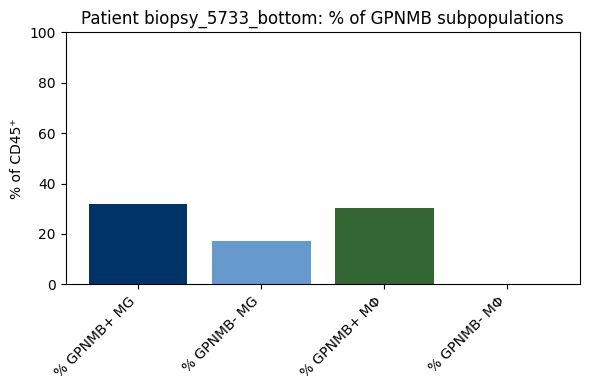

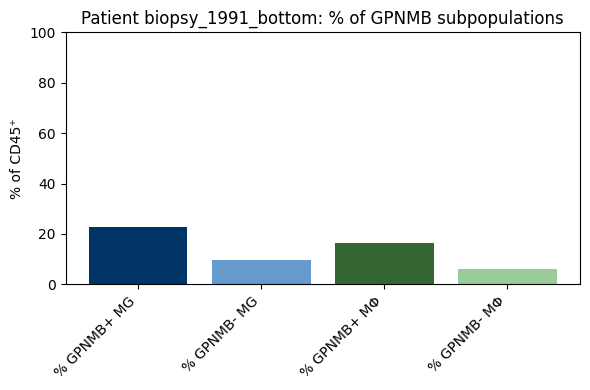

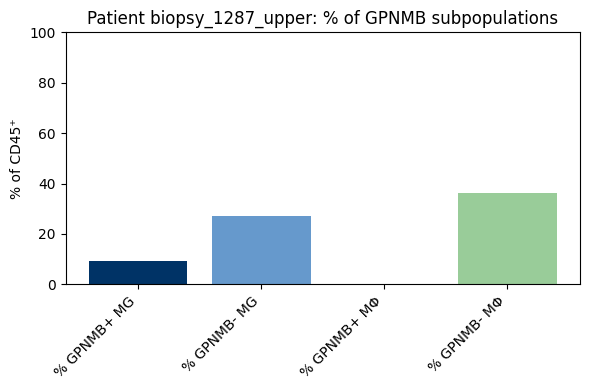

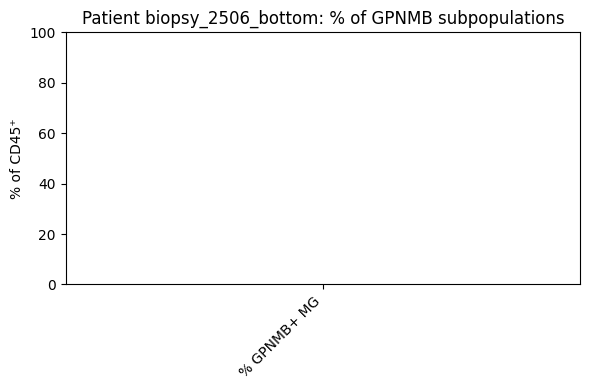

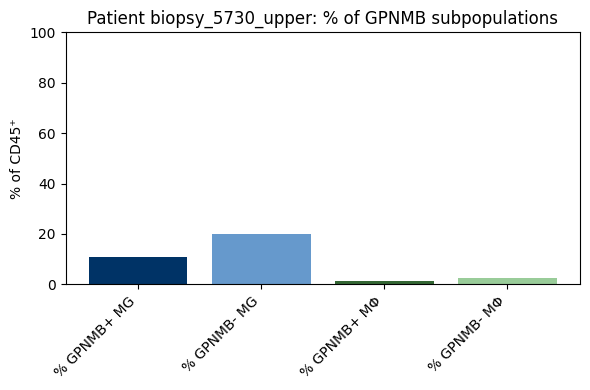

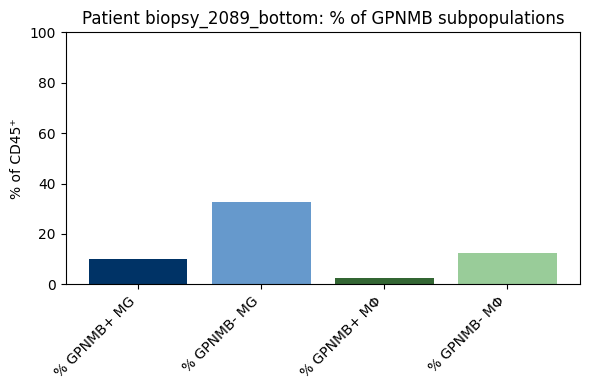

In [9]:
cols = ["% GPNMB+ MG", "% GPNMB- MG", "% GPNMB+ MΦ", "% GPNMB- MΦ"]
colors = ['#003366', '#6699cc', '#336633', '#99cc99']

for idx, row in final_results.iterrows():
    patient_id = row["Biopsy"]
    values = row[cols].values

    plt.figure(figsize=(6,4))
    plt.bar(cols, values, color=colors)
    plt.title(f"Patient {patient_id}: % of GPNMB subpopulations")
    plt.ylabel("% of CD45⁺")
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


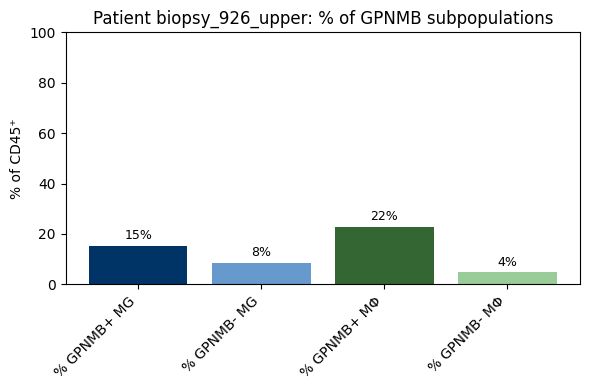

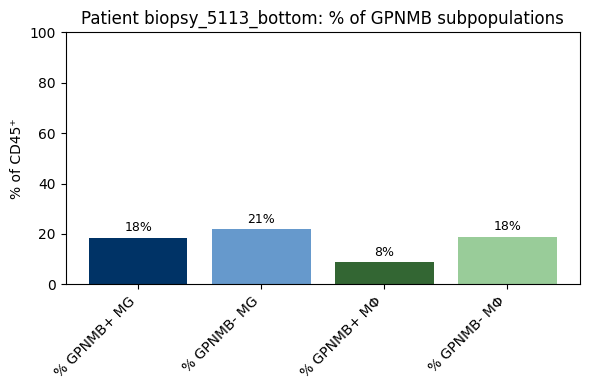

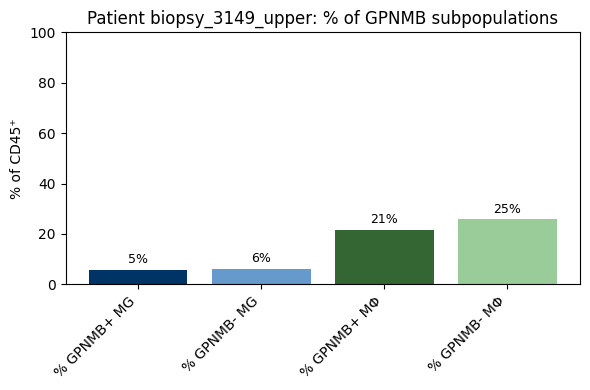

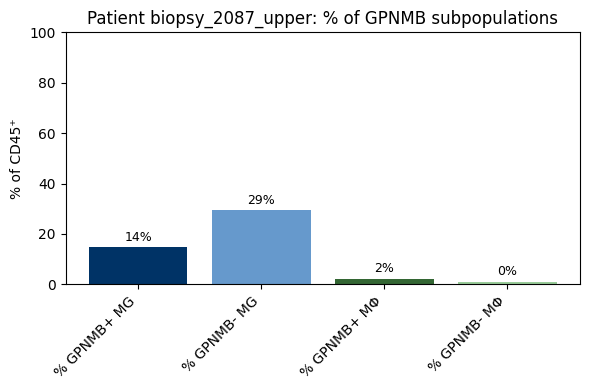

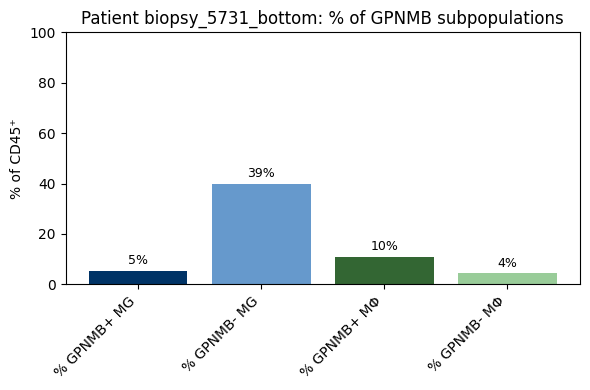

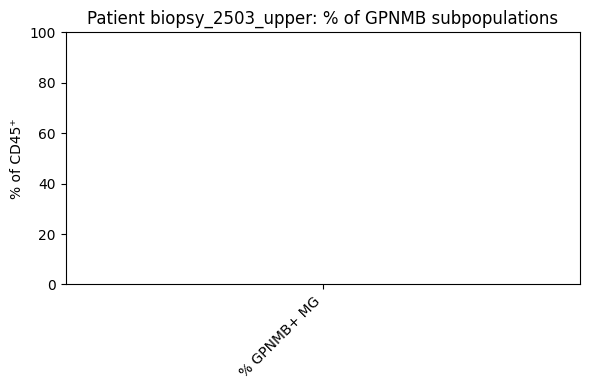

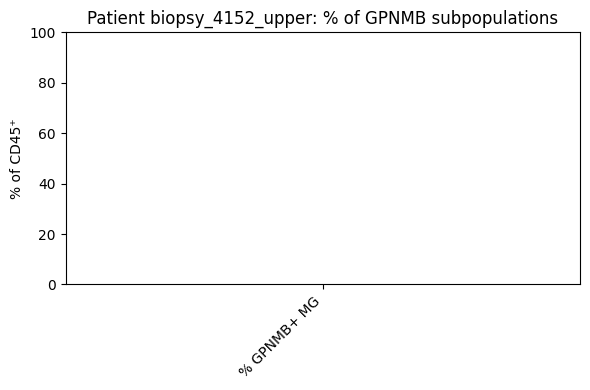

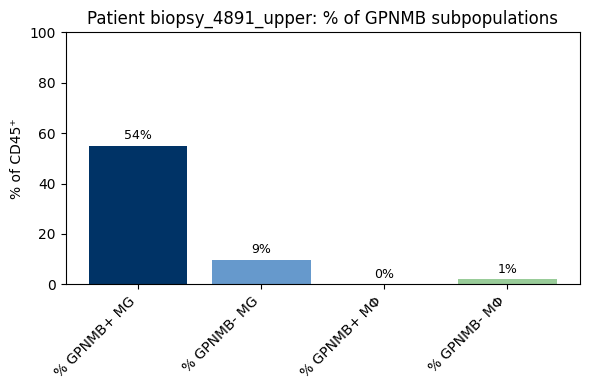

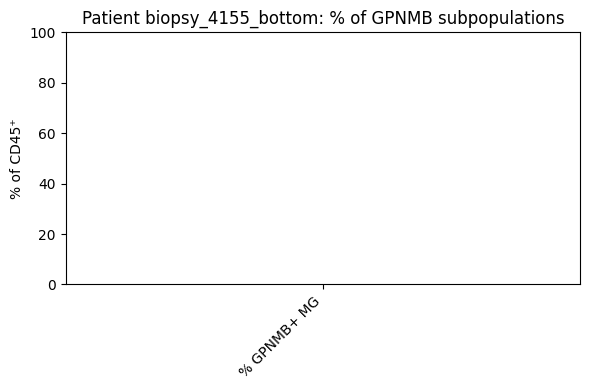

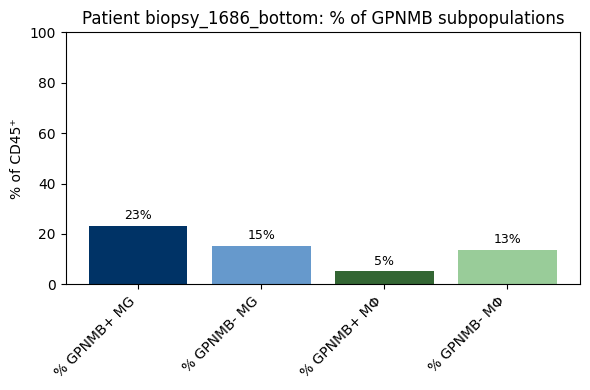

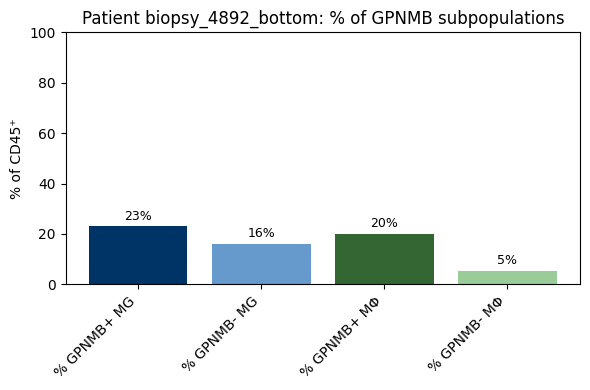

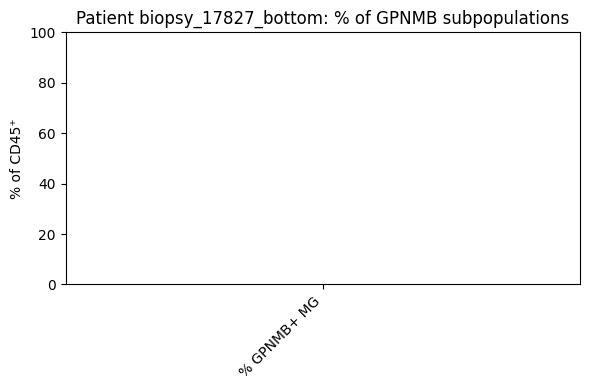

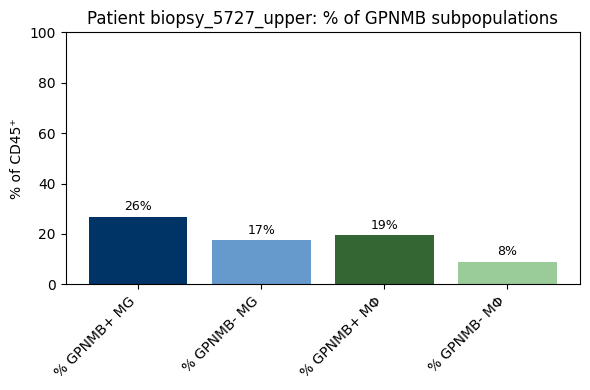

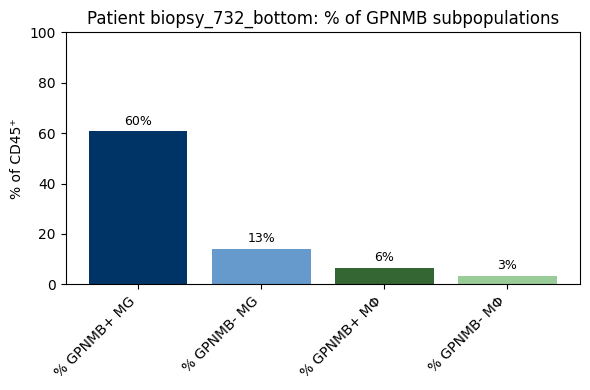

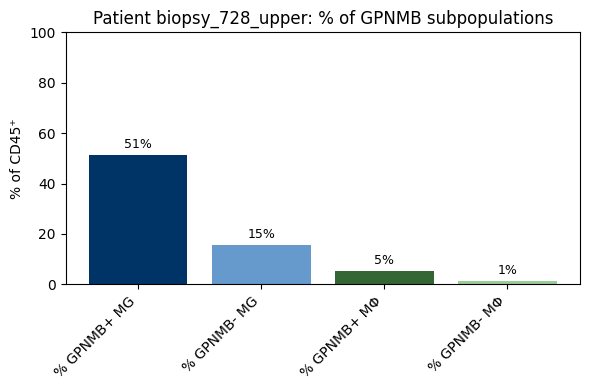

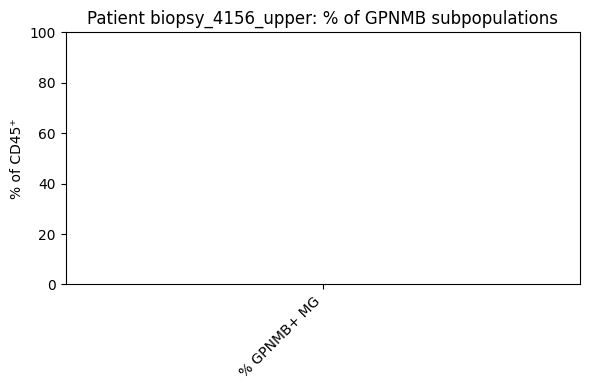

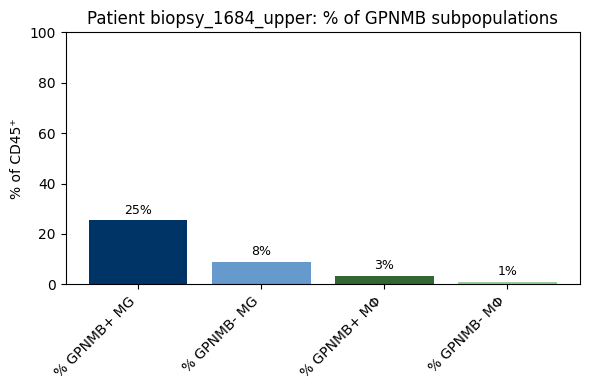

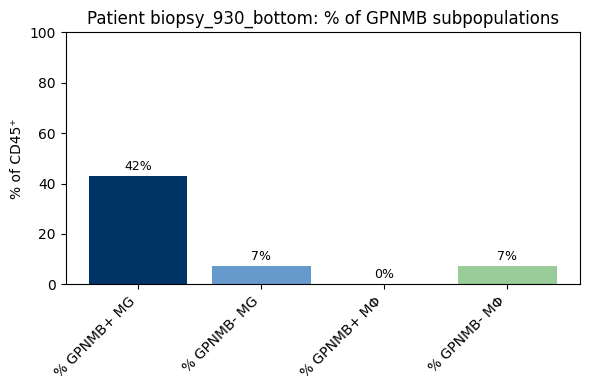

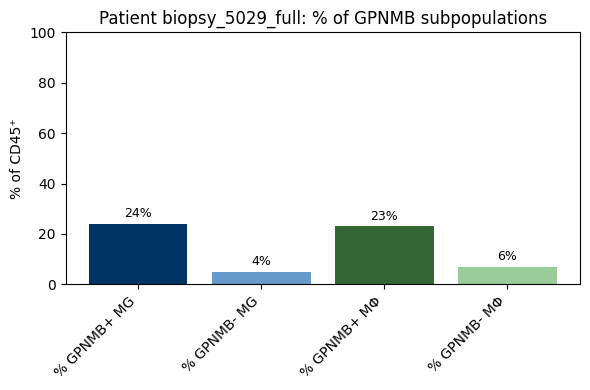

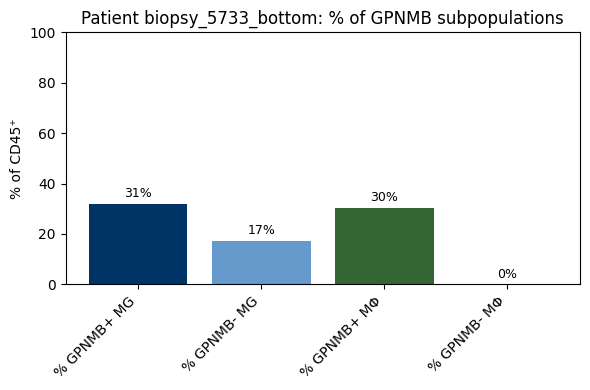

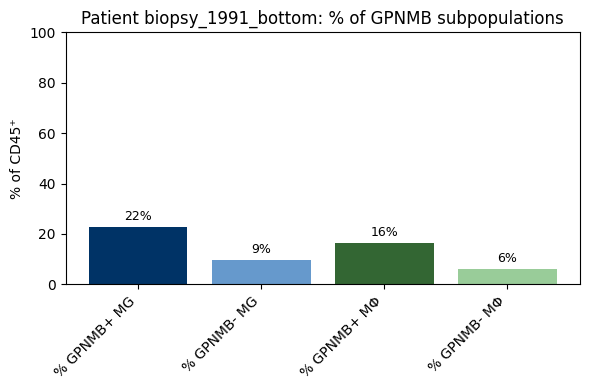

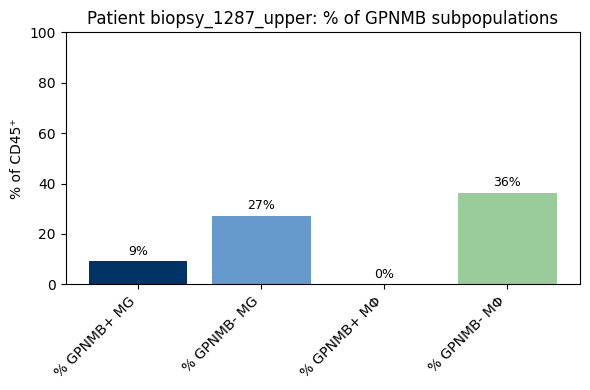

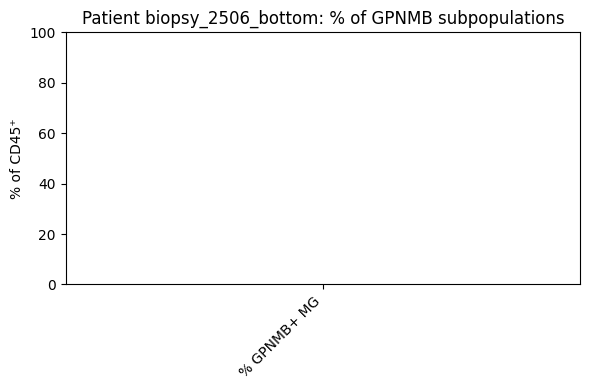

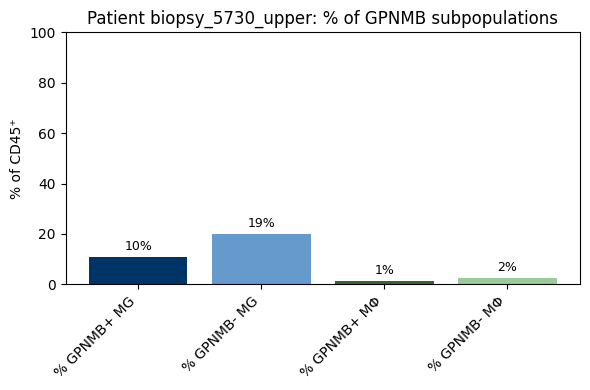

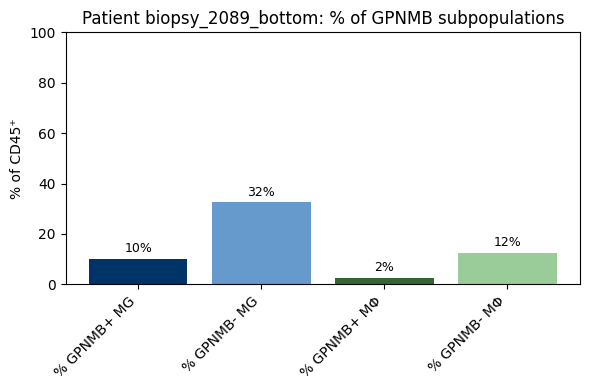

In [17]:
cols = ["% GPNMB+ MG", "% GPNMB- MG", "% GPNMB+ MΦ", "% GPNMB- MΦ"]
colors = ['#003366', '#6699cc', '#336633', '#99cc99']

for idx, row in final_results.iterrows():
    patient_id = row["Biopsy"]
    values = row[cols].values

    plt.figure(figsize=(6,4))
    bars = plt.bar(cols, values, color=colors)

    plt.title(f"Patient {patient_id}: % of GPNMB subpopulations")
    plt.ylabel("% of CD45⁺")
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    # Add exact percentage on top of bars
    for bar in bars:
        height = bar.get_height()
        if np.isnan(height).any():
            continue
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1.5,
            f"{int(height)}%",
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

# Problem 3

In [18]:
mapping_data = [
    ("2506", "bottom", "Diffuse midline glioma H3K27M"),
    ("2503", "upper", "No malignant cells"),
    ("4153", "bottom", "Diffuse midline glioma H3K27M"),
    ("4152", "upper", "Diffuse midline glioma H3K27M"),
    ("4156", "upper", "Diffuse midline glioma H3K27M"),
    ("4891", "upper", "Single malignant cells"),
    ("4892", "bottom", "Diffuse midline glioma H3K27M"),
    ("5029", "full", "Hemispheric pHGG"),
    ("5113", "bottom", "Pilocytic astrocytoma"),
    ("5731", "bottom", "Diffuse midline glioma H3K27M"),
    ("5733", "bottom", "Diffuse midline glioma H3K27M"),
    ("5730", "upper", "Single malignant cells"),
    ("17827", "bottom", "Hemispheric pHGG"),
    ("732", "bottom", "Diffuse midline glioma H3K27M"),
    ("926", "upper", "No malignant cells"),
    ("1684", "upper", "Single malignant cells"),
    ("1686", "bottom", "Diffuse midline glioma H3K27M"),
    ("2087", "upper", "Single malignant cells"),
    ("2089", "bottom", "Diffuse midline glioma H3K27M"),
    ("1991", "bottom", "Diffuse midline glioma H3K27M"),
    ("3149", "upper", "Diffuse midline glioma H3K27M"),
    ("TMA-A2", "full", "Hemispheric pHGG"),
    ("TMA-A8", "full", "Hemispheric pHGG"),
    ("TMA-B6", "full", "Hemispheric pHGG"),
    ("TMA-B4", "full", "Hemispheric pHGG"),
]

mapping_df = pd.DataFrame(mapping_data, columns=["biopsy_number", "position", "Name"])
mapping_df

,biopsy_number,position,Name
0,2506,bottom,Diffuse midline glioma H3K27M
1,2503,upper,No malignant cells
2,4153,bottom,Diffuse midline glioma H3K27M
3,4152,upper,Diffuse midline glioma H3K27M
4,4156,upper,Diffuse midline glioma H3K27M
5,4891,upper,Single malignant cells
6,4892,bottom,Diffuse midline glioma H3K27M
7,5029,full,Hemispheric pHGG
8,5113,bottom,Pilocytic astrocytoma
9,5731,bottom,Diffuse midline glioma H3K27M


In [19]:
def classify_stratum(name):
    if name == "No malignant cells":
        return "NoMC"
    elif name == "Single malignant cells":
        return "SMCs"
    else:
        return "Core"

mapping_df["Stratum"] = mapping_df["Name"].apply(classify_stratum)
mapping_df

,biopsy_number,position,Name,Stratum
0,2506,bottom,Diffuse midline glioma H3K27M,Core
1,2503,upper,No malignant cells,NoMC
2,4153,bottom,Diffuse midline glioma H3K27M,Core
3,4152,upper,Diffuse midline glioma H3K27M,Core
4,4156,upper,Diffuse midline glioma H3K27M,Core
5,4891,upper,Single malignant cells,SMCs
6,4892,bottom,Diffuse midline glioma H3K27M,Core
7,5029,full,Hemispheric pHGG,Core
8,5113,bottom,Pilocytic astrocytoma,Core
9,5731,bottom,Diffuse midline glioma H3K27M,Core


In [20]:
final_results = final_results.merge(
    mapping_df,
    on=["biopsy_number", "position"],
    how="left"
)
final_results

,Biopsy,Total_cells,TMEM119pos_count,TMEM119neg_count,% GPNMB+ MG,% GPNMB- MG,% GPNMB+ MΦ,% GPNMB- MΦ,biopsy_number,position,Name,Stratum
0,biopsy_926_upper,237,25,29,15.238095,8.571429,22.857143,4.761905,926,upper,No malignant cells,NoMC
1,biopsy_5113_bottom,14185,1967,1341,18.395744,21.853898,8.696542,18.743605,5113,bottom,Pilocytic astrocytoma,Core
2,biopsy_3149_upper,12817,646,2619,5.664133,6.026059,21.588853,25.805284,3149,upper,Diffuse midline glioma H3K27M,Core
3,biopsy_2087_upper,487,102,7,14.655172,29.310345,2.155172,0.862069,2087,upper,Single malignant cells,SMCs
4,biopsy_5731_bottom,1544,313,105,5.323741,39.712230,10.791367,4.316547,5731,bottom,Diffuse midline glioma H3K27M,Core
5,biopsy_2503_upper,623,44,59,NaN,NaN,NaN,NaN,2503,upper,No malignant cells,NoMC
6,biopsy_4152_upper,722,83,43,NaN,NaN,NaN,NaN,4152,upper,Diffuse midline glioma H3K27M,Core
7,biopsy_4891_upper,121,33,1,54.901961,9.803922,0.000000,1.960784,4891,upper,Single malignant cells,SMCs
8,biopsy_4155_bottom,9385,649,610,NaN,NaN,NaN,NaN,4155,bottom,NaN,NaN
9,biopsy_1686_bottom,1375,119,58,23.300971,15.210356,5.177994,13.592233,1686,bottom,Diffuse midline glioma H3K27M,Core


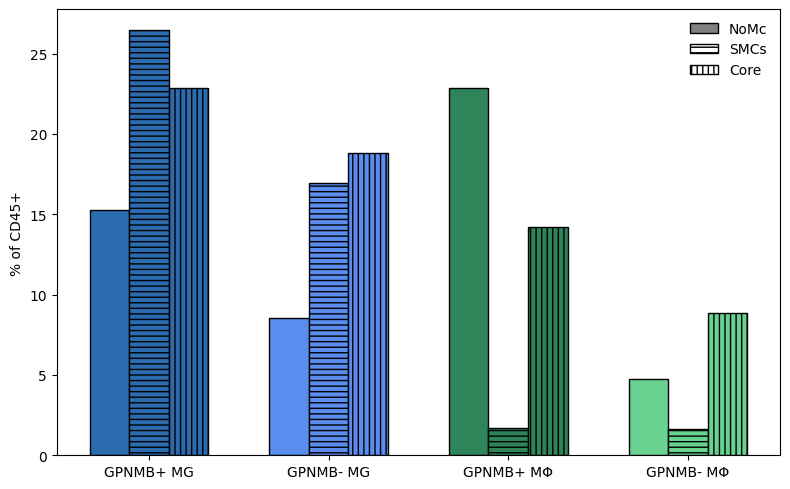

In [21]:
pop_cols = [
    "% GPNMB+ MG",
    "% GPNMB- MG",
    "% GPNMB+ MΦ",
    "% GPNMB- MΦ"
]

exclude_names = ["Hemispheric pHGG", "Pilocytic astrocytoma"]

df_req3 = final_results[~final_results["Name"].isin(exclude_names)].copy()

grouped = (
    df_req3
    .dropna(subset=pop_cols)
    .groupby("Stratum")[pop_cols]
    .mean()
)

strata_order = ["NoMC", "SMCs", "Core"]
grouped = grouped.reindex(strata_order)

x = np.arange(len(pop_cols))
width = 0.22

colors = ["#2b6cb0", "#5a8dee", "#2f855a", "#68d391"]

fig, ax = plt.subplots(figsize=(8,5))

for i, pop in enumerate(pop_cols):
    for j, stratum in enumerate(strata_order):
        
        value = grouped.loc[stratum, pop]
        
        hatch_style = None
        if stratum == "SMCs":
            hatch_style = "---"
        elif stratum == "Core":
            hatch_style = "|||"
        
        ax.bar(
            x[i] + (j-1)*width,
            value,
            width,
            color=colors[i],
            edgecolor="black",
            hatch=hatch_style
        )

ax.set_xticks(x)
ax.set_xticklabels(["GPNMB+ MG", "GPNMB- MG", "GPNMB+ MΦ", "GPNMB- MΦ"])
ax.set_ylabel("% of CD45+")

legend_elements = [
    Patch(facecolor="gray", edgecolor="black", label="NoMc"),
    Patch(facecolor="white", edgecolor="black", hatch="---", label="SMCs"),
    Patch(facecolor="white", edgecolor="black", hatch="|||", label="Core"),
]

ax.legend(handles=legend_elements, frameon=False)

plt.tight_layout()
plt.show()
